The goal of this project is to identify the flower family from a picture. Two functionalities were developed. First one, given a query image, allows finding the k most similar images in a set of reference samples. Second one, given a pair of images, allows to decide if they belong to the same category or not. 

Importing used libraries:

In [314]:
import argparse
import numpy as np
from prettytable import PrettyTable
from matplotlib import pyplot as plt

# Torch stuff
import torch
import torch.nn as nn
from torchvision import datasets, models
import torchvision.transforms as transforms
from pytorch_metric_learning.utils import common_functions as c_f
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import miners, losses
from torch.optim import Adam
import torchmetrics
from torchmetrics import RetrievalMAP

Selecting device:

In [7]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")

Code runs in cpu


/home/kirle/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Code to read the dataset and show some samples:

In [8]:
def show_samples(dataset):

    labels_to_indices = c_f.get_labels_to_indices(dataset.targets)
    indexes = [labels_to_indices[i] for i in np.arange(0,24)]

    cols, rows = 8, 3
    figure = plt.figure(figsize=(cols*2, rows*2))

    for i in range(0, cols * rows):
        sample, label = dataset[indexes[i][0]]
        figure.add_subplot(rows, cols, i+1)
        plt.title(f'Class {dataset.classes[label]}')
        plt.axis("off")
        plt.imshow(sample.permute(1, 2, 0), cmap="gray")
    plt.show()

Train: Dataset ImageFolder
    Number of datapoints: 1071
    Root location: resources/dataset//train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
 Validation: Dataset ImageFolder
    Number of datapoints: 135
    Root location: resources/dataset//valid
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
 Test: Dataset ImageFolder
    Number of datapoints: 56
    Root location: resources/dataset//test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

Labels: ['001', '002', '003', '004', '005', '006', '007', 

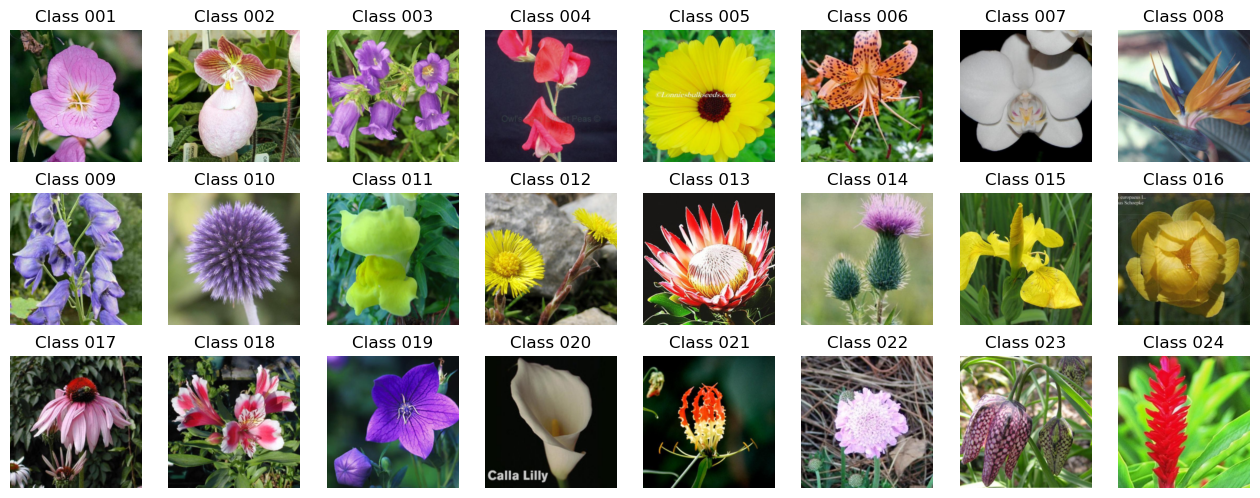

In [45]:
dataPath = "resources/dataset/"

transform = transforms.Compose([
transforms.Resize(224),
transforms.CenterCrop((224, 224)),
transforms.ToTensor()])

dataset_train = datasets.ImageFolder(root=f'{dataPath}/train', transform=transform)
dataset_valid = datasets.ImageFolder(root=f'{dataPath}/valid', transform=transform)
dataset_test = datasets.ImageFolder(root=f'{dataPath}/test', transform=transform)


print(f'Train: {dataset_train}\n', f'Validation: {dataset_valid}\n', f'Test: {dataset_test}\n')
    
# Display labels and samples
print(f"Labels: {dataset_train.classes}")
show_samples(dataset_train)

# Finding k most similar images from a query image

Training functions:

In [12]:
def train(model, loader, f_loss, optimizer, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

        # Backpropagate the error to change the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss/count, correct /count  

def test(model, loader, f_loss, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.eval()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

    return total_loss/count, correct /count  


def train_model(model, train_dataset, valid_dataset, device,
                optimizer, 
                loss,
                batch_size=128, 
                num_epochs=20,
                output_filename='trained-model.pt'):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    
    ### Write your code here
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_loss = float('inf')
    
    for i in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, loss, optimizer, device)
        val_loss, val_acc = train(model, valid_loader, loss, optimizer, device)
        
        # save epoch results
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # save model with lower val_loss
        if (val_loss < best_val_loss): 
            best_val_loss = val_loss
            torch.save(model.state_dict(), output_filename)
        
        # output local epoch results
        print(f"Epoch:{i} -\t- Train loss : {train_loss:.4f} -\t- Train acc : {train_acc:.4f} -\t- Validation loss : {val_loss:.4f} -\t- Validation acc: {val_acc:.4f} \n")
    
    # Plot results
    plt.plot(train_losses,label='Train losses')
    plt.plot(val_losses, label='Validation losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(train_accs, label='Train accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    

First, lets define a simple CNN architecture in order to compute embeddings for a query image and the reference set. The network was defined as a combination of convolutional and maxpooling layers to reduce dimmensionality while increasing the depth of the output space. Batch normalization layers were used to normalize the outputs of the convolutional layers before maxpooling. At last, a combination of Linear layouts with decreasing number of neurons were used to output the embeddings. ReLU activation functions were used as activation functions for each convolutioanl and linear layout. 

In [322]:
class ImageEmbeddingNetwork(nn.Module):
    def __init__(self):
        super(ImageEmbeddingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(50176, 512)  # Adjusted input size
        self.relu5 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.bn1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.pool2(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.bn3(out)
        out = self.pool3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.bn4(out)
        out = self.pool4(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.relu6(out)
        out = self.fc3(out)
        
        return out


As optimizer, Adam was chosen with a learning rate of 1<sup>-4</sup>, and CrossEntropy as the loss function.

In [323]:
embedding_net = ImageEmbeddingNetwork()
embedding_net.to(device)

optimizer=Adam(embedding_net.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()
epochs = 10
batch_size = 64
output_filename = 'trained_model.pt-v2'

In [326]:
print(embedding_net)

ImageEmbeddingNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (bn4): BatchNorm2d(

Epoch:0 -	- Train loss : 5.1913 -	- Train acc : 0.0103 -	- Validation loss : 3.7008 -	- Validation acc: 0.1926 

Epoch:1 -	- Train loss : 3.4172 -	- Train acc : 0.1578 -	- Validation loss : 2.3908 -	- Validation acc: 0.4222 

Epoch:2 -	- Train loss : 2.3656 -	- Train acc : 0.3361 -	- Validation loss : 1.5621 -	- Validation acc: 0.6148 

Epoch:3 -	- Train loss : 1.7532 -	- Train acc : 0.4781 -	- Validation loss : 1.0597 -	- Validation acc: 0.7926 

Epoch:4 -	- Train loss : 1.2115 -	- Train acc : 0.6788 -	- Validation loss : 0.7290 -	- Validation acc: 0.8889 

Epoch:5 -	- Train loss : 0.7332 -	- Train acc : 0.8665 -	- Validation loss : 0.4805 -	- Validation acc: 0.9333 

Epoch:6 -	- Train loss : 0.4108 -	- Train acc : 0.9636 -	- Validation loss : 0.2994 -	- Validation acc: 0.9778 

Epoch:7 -	- Train loss : 0.2001 -	- Train acc : 0.9935 -	- Validation loss : 0.1779 -	- Validation acc: 1.0000 

Epoch:8 -	- Train loss : 0.1009 -	- Train acc : 1.0000 -	- Validation loss : 0.0953 -	- Validati

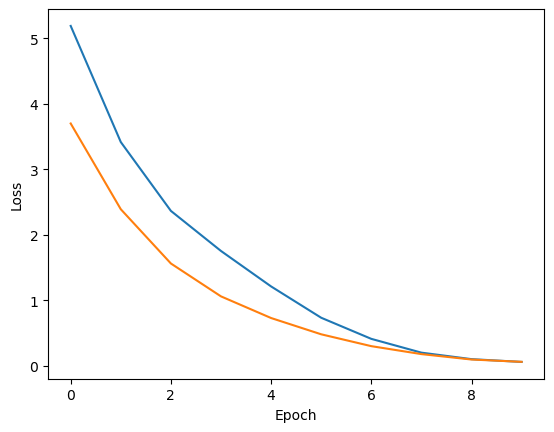

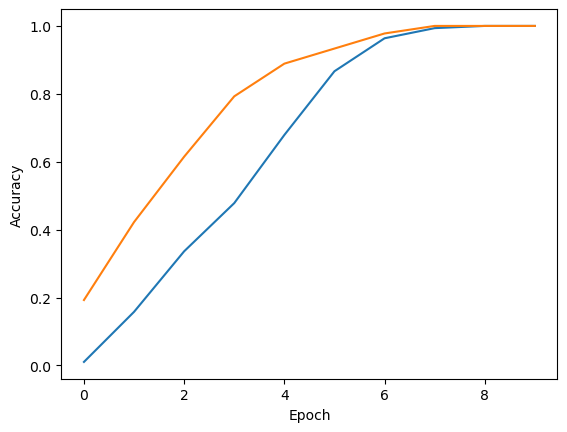

In [19]:
train_model(embedding_net, dataset_train, dataset_valid, device,
                optimizer, 
                loss,
                batch_size=batch_size, 
                num_epochs=epochs,
                output_filename=output_filename)

Loading the trained model:

In [ ]:
checkpoint = torch.load('trained_model.pt')
model = ImageEmbeddingNetwork()
model.load_state_dict(checkpoint, strict=False)
model.to(device)

Computing embeddings for the reference set:

In [ ]:
reference_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
query_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

reference_embeddings = []
model.eval()

with torch.no_grad(): #deactivate gradient computing during this
    for images, _ in reference_loader:
        images = images.to(device)
        embeddings = embedding_net(images)
        reference_embeddings.append(embeddings)
reference_embeddings = torch.cat(reference_embeddings, dim=0) # concating embeddings on our list

Taking a query image from the test set and computing its embeddings:

In [ ]:
query_image = dataset_test[0][0]  
query_image = query_image.unsqueeze(0).to(device) # unsqueeze is to add an additional dimmension to the tensor (batch size)
embedding_net.eval()
with torch.no_grad():
    query_embedding = embedding_net(query_image)


Computing distances of the query image with the embeddings and ranking the k=10 nearest ones by the Euclidean distance metric:

In [ ]:
distances = []
for ref_embedding in reference_embeddings:
    distance = torch.norm(query_embedding - ref_embedding) # using euclidean distance metric
    distances.append(distance.item())

k = 10
indices = list(range(len(distances)))
sorted_indices = sorted(indices, key=distances.__getitem__)[:k]

Showing results:

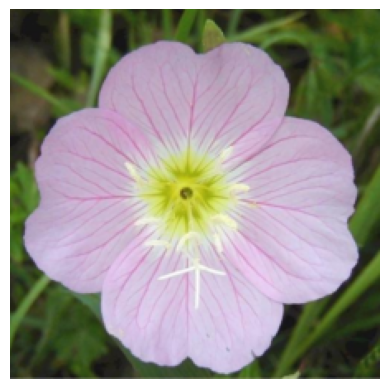

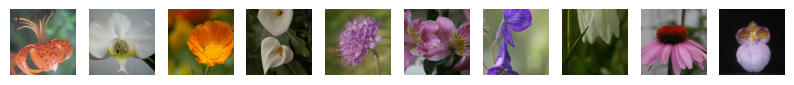

In [43]:
# show query image
query_image, _ = dataset_test[0]
plt.imshow(query_image.permute(1, 2, 0))
plt.axis('off')
plt.show()


fig, axes = plt.subplots(1, k, figsize=(10, 10))
for i, index in enumerate(sorted_indices):
    image, _ = dataset_train[index]
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].axis('off')

plt.show()

The training shows almost perfect accuracy results. However, the comparission of images is pretty bad. We can conclude than the embeddings compute by the network are pretty poor. Maybe the features used were enought to train a classifier, but no sufficient to define a good embedding space were the embeddings were sufficient separated. For this reason I have tried to use directly a pretrained network, such as VGG19.  

For this second try VGG19 were used changing just the last Sequential block to adapt it for this problem. With just 10 epochs, accuracy is worse than in the previous network, but embeddings seems to be much better to fit this problem. 

In [334]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Epoch:0 -	- Train loss : 3.1861 -	- Train acc : 0.0355 -	- Validation loss : 3.1694 -	- Validation acc: 0.0519 

Epoch:1 -	- Train loss : 3.1600 -	- Train acc : 0.1186 -	- Validation loss : 3.1154 -	- Validation acc: 0.1704 

Epoch:2 -	- Train loss : 3.1103 -	- Train acc : 0.1746 -	- Validation loss : 3.0486 -	- Validation acc: 0.2815 

Epoch:3 -	- Train loss : 3.0244 -	- Train acc : 0.2913 -	- Validation loss : 2.9462 -	- Validation acc: 0.4370 

Epoch:4 -	- Train loss : 2.9310 -	- Train acc : 0.4267 -	- Validation loss : 2.8642 -	- Validation acc: 0.4889 

Epoch:5 -	- Train loss : 2.8515 -	- Train acc : 0.5014 -	- Validation loss : 2.8032 -	- Validation acc: 0.5111 

Epoch:6 -	- Train loss : 2.7969 -	- Train acc : 0.5294 -	- Validation loss : 2.7635 -	- Validation acc: 0.5407 

Epoch:7 -	- Train loss : 2.7614 -	- Train acc : 0.5462 -	- Validation loss : 2.7362 -	- Validation acc: 0.5556 

Epoch:8 -	- Train loss : 2.7337 -	- Train acc : 0.5696 -	- Validation loss : 2.7144 -	- Validati

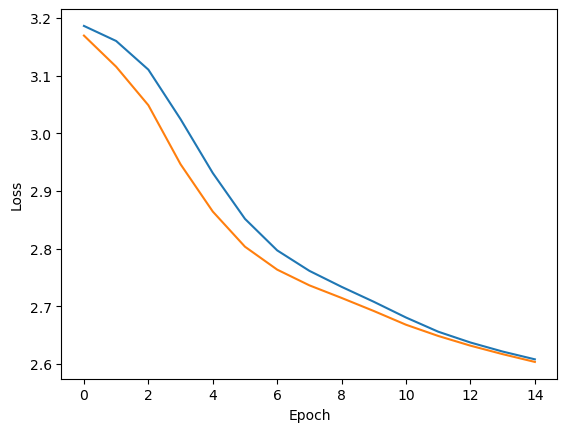

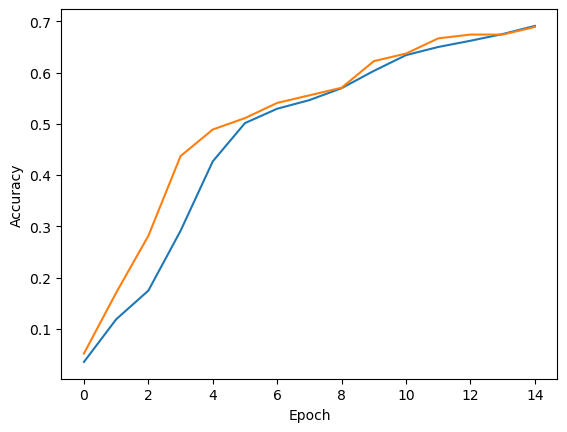

In [13]:
model = models.vgg19(weights=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(nn.Linear(num_features, 32),
                         nn.ReLU(),
                        nn.Linear(32, 24), 
                        nn.Softmax(dim=1))
model.to(device)
optimizer=Adam(model.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()
epochs = 15
batch_size = 64
output_filename = 'trained_model.pt-v2'

train_model(model, dataset_train, dataset_valid, device,
                optimizer, 
                loss,
                batch_size=batch_size, 
                num_epochs=epochs,
                output_filename=output_filename)


Lets define some functions to summary code:

In [107]:
def compute_embedding(query_index): 
    query_image = dataset_test[query_index][0]  
    query_image = query_image.unsqueeze(0).to(device) # unsqueeze is to add an additional dimmension to the tensor (batch size)
    model.eval()
    with torch.no_grad():
        query_embedding = model(query_image)
        
    return query_embedding, dataset_test[query_index][1]

def get_k_nearest(k, ref_embedddings, query_embedding, dataset_train, dataset_test, plot=False):
    distances = []
    for ref_embedding in ref_embedddings:
        distance = torch.norm(query_embedding - ref_embedding) # using euclidean distance metric
        distances.append(distance.item())
        
    indices = list(range(len(distances)))
    sorted_indices = sorted(indices, key=distances.__getitem__)[:k]
    
    if plot:
        # show query image
        query_image, _ = dataset_test[query_index]
        plt.imshow(query_image.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

        fig, axes = plt.subplots(1, k, figsize=(10, 10))
        for i, index in enumerate(sorted_indices):
            image, _ = dataset_train[index]
            axes[i].imshow(image.permute(1, 2, 0))
            axes[i].axis('off')

        plt.show()
    
    return sorted_indices

def compute_precision(sorted_indices, dataset_train, query_label):
    true_positives = sum(1 for index in sorted_indices if dataset_train[index][1] == query_label)
    precision = true_positives / len(sorted_indices)
    return precision




Computing embeddings again for reference set and query image, using again Euclidean distance as distance metric and precission as performance metric:

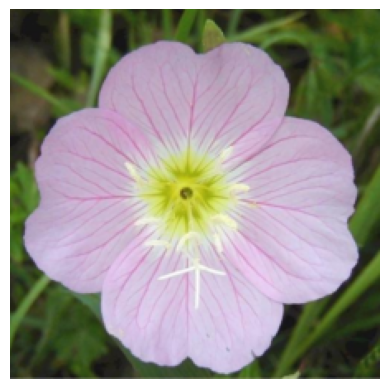

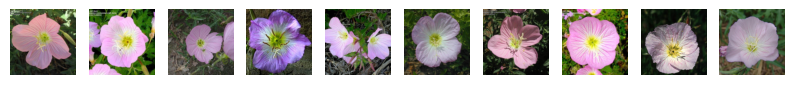

Precision : 1.0


In [85]:
checkpoint = torch.load('trained_model-v2.pt')
model.load_state_dict(checkpoint, strict=False)
model.to(device)

reference_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
query_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

# Compute reference embeddings from training set
reference_embeddings = []
model.eval()

with torch.no_grad(): #deactivate gradient computing during this
    for images, _ in reference_loader:
        images = images.to(device)
        embeddings = model(images)
        reference_embeddings.append(embeddings)
reference_embeddings = torch.cat(reference_embeddings, dim=0) # concating embeddings on our list

k=10
query_index = 0
query_embedding, query_label = compute_embedding(query_index)
sorted_indices = get_k_nearest(k, reference_embeddings, query_embedding, dataset_train, dataset_test, plot=True)
print("Precision : " + str(compute_precision(sorted_indices, dataset_train, query_label)))

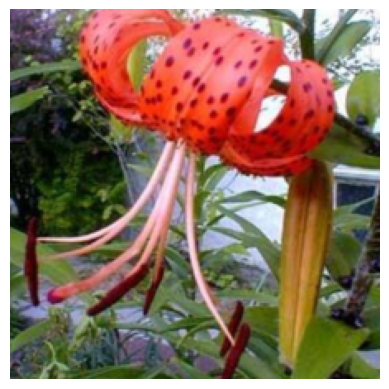

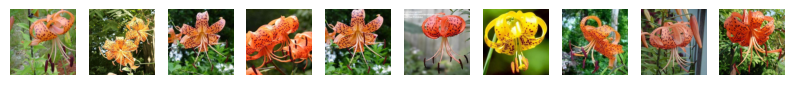

Precision : 1.0


In [87]:
query_index = 11
query_embedding, query_label = compute_embedding(query_index)
sorted_indices = get_k_nearest(k, reference_embeddings, query_embedding, dataset_train, dataset_test, plot=True)
print("Precision : " + str(compute_precision(sorted_indices, dataset_train, query_label)))

Ranking the k nearest ones using Euclidean distance as metric:

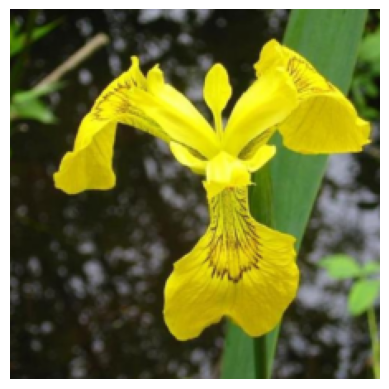

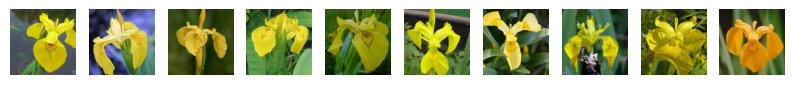

Precision : 1.0


In [88]:
query_index = 33
query_embedding, query_label = compute_embedding(query_index)
sorted_indices = get_k_nearest(k, reference_embeddings, query_embedding, dataset_train, dataset_test, plot=True)
print("Precision : " + str(compute_precision(sorted_indices, dataset_train, query_label)))

Computing mean precision:

In [90]:
dataset_test = datasets.ImageFolder(root=f'{dataPath}/test', transform=transform)
query_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)
model.eval()
query_embeddings = []


metrics_results = []
k = 10

with torch.no_grad(): 
    # iterating through images and computing distance between query image and reference set embeddings
    for i, (query_image, query_label) in enumerate(query_loader):
        query_index = i
    
        query_embedding, query_label = compute_embedding(query_index)
        sorted_indices = get_k_nearest(k, reference_embeddings, query_embedding, dataset_train, 
                                       dataset_test, plot=False)
        
        precission = compute_precision(sorted_indices, dataset_train, query_label)
        metrics_results.append(precission) # save for later
        
# mean precission
mean_precision = np.mean(metrics_results)     
print("Mean Precision:", mean_precision)  


Mean Precision: 0.7107142857142856


It can be seen that results are much better with the embeddings computted by the fine-tuned VGG19, having some problems with cactus and another classes, but with an acceptable average precission.

## Finding k most similar images using Contrastive Loss

Now lets repeat the process again using Contrastive Loss as loss function. For that, the train functions are redefined. 

In [91]:
def train(model, loader, f_loss, optimizer, device, miner):
    count = 0
    total_loss = 0.0

    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        
        miner_output = miner(outputs, targets)
        
        # Compute the loss
        loss = f_loss(outputs, targets, miner_output)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)

        # Backpropagate the error to change the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return total_loss/count 

def train_model(model, train_dataset, valid_dataset, device,
                optimizer, 
                miner,
                loss,
                batch_size=128, 
                num_epochs=20,
                output_filename='trained-model.pt'):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    
    ### Write your code here
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for i in range(num_epochs):
        train_loss = train(model, train_loader, loss, optimizer, device,miner)
        val_loss = train(model, valid_loader, loss, optimizer, device,miner)
        
        # save epoch results
        train_losses.append(train_loss)        
        val_losses.append(val_loss)
        
        # save model with lower val_loss
        if (val_loss < best_val_loss): 
            best_val_loss = val_loss
            torch.save(model.state_dict(), output_filename)
        
        # output local epoch results
        print(f"Epoch:{i} -\t- Train loss : {train_loss:.4f}  -\t- Validation loss : {val_loss:.4f} \n")
    
    # Plot results
    plt.plot(train_losses,label='Train losses')
    plt.plot(val_losses, label='Validation losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    


Model was trained again with the new loss function:

Epoch:0 -	- Train loss : 0.9448  -	- Validation loss : 0.8369 

Epoch:1 -	- Train loss : 0.7515  -	- Validation loss : 0.8864 

Epoch:2 -	- Train loss : 0.6536  -	- Validation loss : 0.7548 

Epoch:3 -	- Train loss : 0.5172  -	- Validation loss : 0.7143 

Epoch:4 -	- Train loss : 0.4134  -	- Validation loss : 0.6644 

Epoch:5 -	- Train loss : 0.4845  -	- Validation loss : 0.6402 

Epoch:6 -	- Train loss : 0.3509  -	- Validation loss : 0.6279 

Epoch:7 -	- Train loss : 0.4317  -	- Validation loss : 0.5608 

Epoch:8 -	- Train loss : 0.2960  -	- Validation loss : 0.5330 

Epoch:9 -	- Train loss : 0.4220  -	- Validation loss : 0.5072 



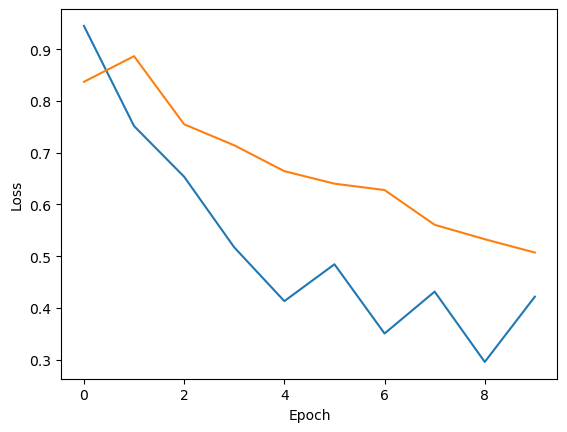

In [99]:
model = models.vgg19(weights=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(nn.Linear(num_features, 32))

model.to(device)
optimizer=Adam(model.parameters(), lr=0.0001)
loss = losses.ContrastiveLoss()
epochs = 10
batch_size = 64
output_filename = 'trained_model-v4.pt'
miner = miners.PairMarginMiner() 

train_model(model, dataset_train, dataset_valid, device,
                optimizer, 
                miner,
                loss,
                batch_size=batch_size, 
                num_epochs=epochs,
                output_filename=output_filename)

As sampling method, Random sampling is chosen. The training set is sampling randomly and indices are saved to compute precission afterwards:

In [167]:
from torch.utils.data.sampler import RandomSampler

# Random sampling for training dataset
random_sampler = RandomSampler(dataset_train)
reference_loader = data.DataLoader(dataset_train, batch_size=batch_size, sampler=random_sampler)
query_loader = data.DataLoader(dataset_test, batch_size=1, shuffle=False)

random_indices = list(random_sampler)

# Compute reference embeddings from training set
reference_embeddings = []
embeddings_indexes = []

model.eval()

with torch.no_grad():  
    for images, _ in reference_loader:
        images = images.to(device)
        embeddings = model(images)
        reference_embeddings.append(embeddings) #64
        embeddings_indexes.append(index)
                
reference_embeddings = torch.cat(reference_embeddings, dim=0)  # concatenate embeddings into a single tensor

# Saving labels and indixes when computing reference set embeddings
reference_embeddings = []
embeddings_labels = []

model.eval()

with torch.no_grad():  
    for images, labels in reference_loader:
        images = images.to(device)
        embeddings = model(images)
        reference_embeddings.append(embeddings)
        embeddings_labels.extend(labels.numpy())

reference_embeddings = torch.cat(reference_embeddings, dim=0)

# Ordering by distance
k = 10
distances = []
for ref_embedding, ref_label in zip(reference_embeddings, embeddings_labels):   
    distance = torch.norm(query_embedding - ref_embedding)  # using euclidean distance metric
    distances.append((distance.item(), ref_label))

distances.sort(key=lambda x: x[0])  # Ordena por distancia
k_nearest = distances[:k]  # Selecciona los k más cercanos

# Computing and printing precission at last
true_positives = sum(1 for _, label in k_nearest if label == query_label)
precision = true_positives / len(k_nearest)

print("Precision:", precision)

Precision: 1.0


In [168]:
k_nearest

[(1.9010138511657715, 0),
 (1.9792200326919556, 0),
 (2.0602800846099854, 0),
 (2.081075429916382, 0),
 (2.285566568374634, 0),
 (2.290346622467041, 0),
 (2.347395181655884, 0),
 (2.3525948524475098, 0),
 (2.3717682361602783, 0),
 (2.458333730697632, 0)]

In [105]:
dataset_test = datasets.ImageFolder(root=f'{dataPath}/test', transform=transform)
query_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)
model.eval()
query_embeddings = []


metrics_results = []
k = 10

with torch.no_grad(): 
    # iterating through images and computing distance between query image and reference set embeddings
    for i, (query_image, query_label) in enumerate(query_loader):
        query_index = i
    
        query_embedding, query_label = compute_embedding(query_index)
        sorted_indices = get_k_nearest(k, reference_embeddings, query_embedding, dataset_train, 
                                       dataset_test, plot=False)
        
        precission = compute_precision(sorted_indices, dataset_train, query_label)
        metrics_results.append(precission) # save for later
        
# mean precission
mean_precision = np.mean(metrics_results)     
print("Mean Precision:", mean_precision)  

Mean Precision: 0.7982142857142858


Precission with this loss function increases almost 9% comparing to Cross Entropy loss, being this a better approach.

# Given a pair of images, decide if their belong to the same category or not

For this functionality, two functions are performed. One is just to plot results, while same_class() compares the distances using a given threshold. Instead of Euclidean distance, for this case cosine similarity was used. Cosine similarity ranges from -1 to 1, where 1 indicates perfect similarity. 

In [299]:
def same_class(query_embedding, reference_embedding, threshold):
    # using cosine distance instead because of range [-1,1]
    distance = torch.cosine_similarity(query_embedding, reference_embedding)
    print(distance)
    if distance < threshold:
        print("False")
        return False
    else:
        print("True")
        return True
        
def plot_images(image1, image2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Convert image data to NumPy array and adjust dimensions if needed
    image1 = np.transpose(image1, (1, 2, 0)) if image1.shape[0] == 3 else image1
    image2 = np.transpose(image2, (1, 2, 0)) if image2.shape[0] == 3 else image2

    axes[0].imshow(image1)
    axes[0].set_title("Image 1 -" + str(label1))
    axes[1].imshow(image2)
    axes[1].set_title("Image 2 - " + str(label2) )

    plt.tight_layout()
    plt.show()

In [303]:
print(len(dataset_test))

56


Lets check similarity between the some images and each other image on the test set and compute metrics:

In [ ]:
query_index = 0
query_image, query_label = dataset_test[query_index]

false_negatives = 0
false_positives = 0
true_positives = 0
true_negatives = 0

for i in range(55):
    reference_index = i
    reference_image, reference_label = dataset_test[reference_index]

    threshold = 0.88

    query_embedding, query_label = compute_embedding(query_index)
    reference_embedding, reference_label = compute_embedding(reference_index)

    same = same_class(query_embedding, reference_embedding, threshold)
    plot_images(query_image, reference_image, query_label, reference_label)

    true_positives += 1 if same and query_label == reference_label else 0
    true_negatives += 1 if not same and query_label != reference_label else 0
    false_negatives += 1 if not same and query_label == reference_label else 0
    false_positives += 1 if same and query_label != reference_label else 0


In [345]:
print("True Positives:", true_positives)
print("True Negatives:", true_negatives)
print("False Positives:", false_positives)
print("False Negatives:", false_negatives)

True Positives: 3
True Negatives: 50
False Positives: 2
False Negatives: 0


In [346]:
confusion_matrix = [[true_positives, false_positives],
                    [false_negatives, true_negatives]]
table = PrettyTable()
table.field_names = ["", "Predicted Positive", "Predicted Negative"]
table.add_row(["Actual Positive", confusion_matrix[0][0], confusion_matrix[0][1]])
table.add_row(["Actual Negative", confusion_matrix[1][0], confusion_matrix[1][1]])
print("Confusion Matrix:")
print(table)

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Positive | Predicted Negative |
+-----------------+--------------------+--------------------+
| Actual Positive |         3          |         2          |
| Actual Negative |         0          |         50         |
+-----------------+--------------------+--------------------+


In [347]:
# Compute metrics
accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / sum(sum(confusion_matrix, []))
recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
precision = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-score:", f1_score)


Accuracy: 0.9636363636363636
Recall: 1.0
F1-score: 0.7499999999999999


In [ ]:
query_index = 30
query_image, query_label = dataset_test[query_index]

false_negatives = 0
false_positives = 0
true_positives = 0
true_negatives = 0

for i in range(55):
    reference_index = i
    reference_image, reference_label = dataset_test[reference_index]

    threshold = 0.88

    query_embedding, query_label = compute_embedding(query_index)
    reference_embedding, reference_label = compute_embedding(reference_index)

    same = same_class(query_embedding, reference_embedding, threshold)
    plot_images(query_image, reference_image, query_label, reference_label)

    true_positives += 1 if same and query_label == reference_label else 0
    true_negatives += 1 if not same and query_label != reference_label else 0
    false_negatives += 1 if not same and query_label == reference_label else 0
    false_positives += 1 if same and query_label != reference_label else 0


In [349]:
confusion_matrix = [[true_positives, false_positives],
                    [false_negatives, true_negatives]]
table = PrettyTable()
table.field_names = ["", "Predicted Positive", "Predicted Negative"]
table.add_row(["Actual Positive", confusion_matrix[0][0], confusion_matrix[0][1]])
table.add_row(["Actual Negative", confusion_matrix[1][0], confusion_matrix[1][1]])
print("Confusion Matrix:")
print(table)

Confusion Matrix:
+-----------------+--------------------+--------------------+
|                 | Predicted Positive | Predicted Negative |
+-----------------+--------------------+--------------------+
| Actual Positive |         3          |         6          |
| Actual Negative |         0          |         46         |
+-----------------+--------------------+--------------------+


In [350]:
# Compute metrics
accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / sum(sum(confusion_matrix, []))
recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
precision = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-score:", f1_score)


Accuracy: 0.8909090909090909
Recall: 1.0
F1-score: 0.5
